<a href="https://colab.research.google.com/github/Maoelan/Project-Image-Classification-Deployment-TFLite_Dicoding/blob/main/Project_Image_Classification_Mask_Classification_TensorFlow_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile,os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input

Dataset : https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection

In [24]:
local_zip = '/content/drive/MyDrive/datasets/mask.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/datasets')
zip_ref.close()

In [25]:
os.listdir('/content/drive/MyDrive/datasets/Dataset')

['mask_weared_incorrect', 'with_mask', 'without_mask']

In [26]:
train_dir = os.path.join('/content/drive/MyDrive/datasets/Dataset')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 256,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 128,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


In [27]:
model = tf.keras.models.Sequential([
    VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 512)               33280     
                                                      

In [29]:
model.compile(optimizer = tf.optimizers.experimental.Adam(lr=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai > 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [30]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 50, 
                    validation_steps = 5,callbacks=[callbacks], verbose = 2)

Epoch 1/50
29/29 - 106s - loss: 1.1494 - accuracy: 0.4271 - val_loss: 0.8771 - val_accuracy: 0.5578 - 106s/epoch - 4s/step
Epoch 2/50
29/29 - 77s - loss: 0.8417 - accuracy: 0.5857 - val_loss: 0.7726 - val_accuracy: 0.6484 - 77s/epoch - 3s/step
Epoch 3/50
29/29 - 77s - loss: 0.6622 - accuracy: 0.7330 - val_loss: 0.4177 - val_accuracy: 0.8313 - 77s/epoch - 3s/step
Epoch 4/50
29/29 - 78s - loss: 0.4571 - accuracy: 0.8286 - val_loss: 0.3943 - val_accuracy: 0.8547 - 78s/epoch - 3s/step
Epoch 5/50
29/29 - 76s - loss: 0.3545 - accuracy: 0.8670 - val_loss: 0.3383 - val_accuracy: 0.8703 - 76s/epoch - 3s/step
Epoch 6/50
29/29 - 76s - loss: 0.4881 - accuracy: 0.8161 - val_loss: 0.3804 - val_accuracy: 0.8578 - 76s/epoch - 3s/step
Epoch 7/50
29/29 - 76s - loss: 0.3687 - accuracy: 0.8666 - val_loss: 0.3160 - val_accuracy: 0.8984 - 76s/epoch - 3s/step
Epoch 8/50
29/29 - 76s - loss: 0.2712 - accuracy: 0.9051 - val_loss: 0.1852 - val_accuracy: 0.9312 - 76s/epoch - 3s/step
Epoch 9/50
29/29 - 77s - loss:

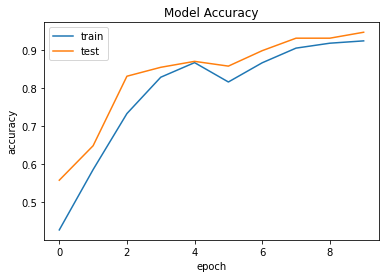

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

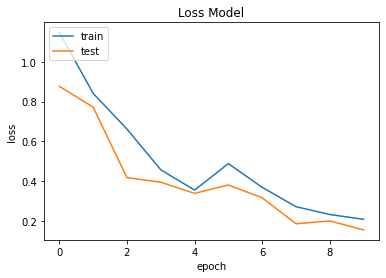

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
import pathlib

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

60711908